In [1]:
# imports
import datetime
from datetime import datetime as dttm
from datetime import date
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from geopy.geocoders import Nominatim
from sklearn.linear_model import Ridge
from datetime import timedelta
from sklearn.metrics import mean_absolute_error

In [2]:
# location name to coordinates
def coord(location):
    geolocator = Nominatim(user_agent = "predictor")
    return geolocator.geocode(location)

In [3]:
# set time period
today = date.today()
de = int(today.strftime("%d"))
me = int(today.strftime("%m"))
ye = int(today.strftime("%Y"))
start = dttm(2021, 1, 2)
end = dttm(ye, me, de)

In [4]:
# get place
city = input('Enter a city - ')
x = coord(city)
lat = int(x.latitude)
lon = int(x.longitude)
place = Point(lat, lon)
#place = Point(21.2120677, 81.3732849)

Enter a city - bhilai


In [5]:
# get data
data = Daily(place, start, end)
data = data.fetch()

In [6]:
weather = pd.DataFrame(data)
weather.drop(['tavg', 'snow', 'wspd', 'wdir', 'wpgt', 'pres', 'tsun'], axis = 1, inplace = True)
print(weather)

            tmin  tmax  prcp
time                        
2021-01-02  13.3  26.4   0.0
2021-01-03  12.4  28.6   0.0
2021-01-04  14.5  26.6   0.0
2021-01-05  14.3  27.6   0.0
2021-01-06  16.2  30.0   0.0
...          ...   ...   ...
2023-02-28  18.2  33.3   0.0
2023-03-01  17.6  33.3   0.0
2023-03-02  19.1  33.3   0.0
2023-03-03  19.8  34.6   0.0
2023-03-04  19.5  34.1   0.0

[792 rows x 3 columns]


In [7]:
weather.apply(pd.isnull).sum()

tmin    2
tmax    2
prcp    2
dtype: int64

In [8]:
weather['prcp'] = weather['prcp'].fillna(0)

In [9]:
weather[pd.isnull(weather['tmax'])]

,tmin,tmax,prcp
time,,,
2022-05-26,NaN,NaN,0.0
2022-05-27,NaN,NaN,0.0


In [10]:
weather = weather.fillna(method = 'ffill')

In [11]:
weather.apply(pd.isnull).sum()

tmin    0
tmax    0
prcp    0
dtype: int64

In [12]:
weather.dtypes

tmin    float64
tmax    float64
prcp    float64
dtype: object

In [13]:
weather.index

DatetimeIndex(['2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09',
               '2021-01-10', '2021-01-11',
               ...
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03', '2023-03-04'],
              dtype='datetime64[ns]', name='time', length=792, freq='D')

<Axes: xlabel='time'>

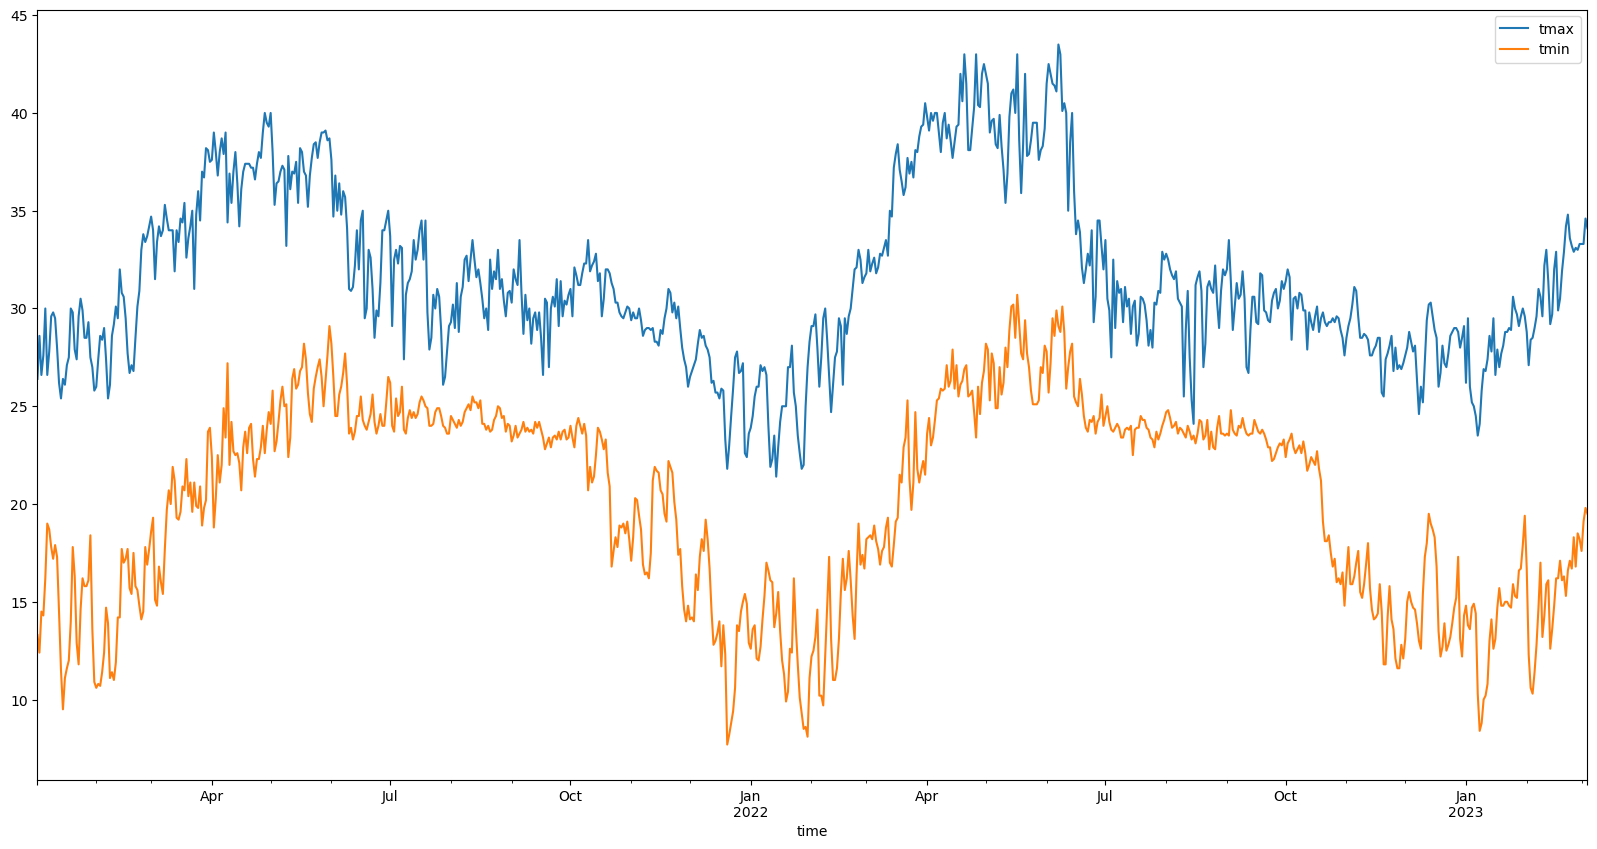

In [14]:
weather[['tmax', 'tmin']].plot()

<Axes: xlabel='time'>

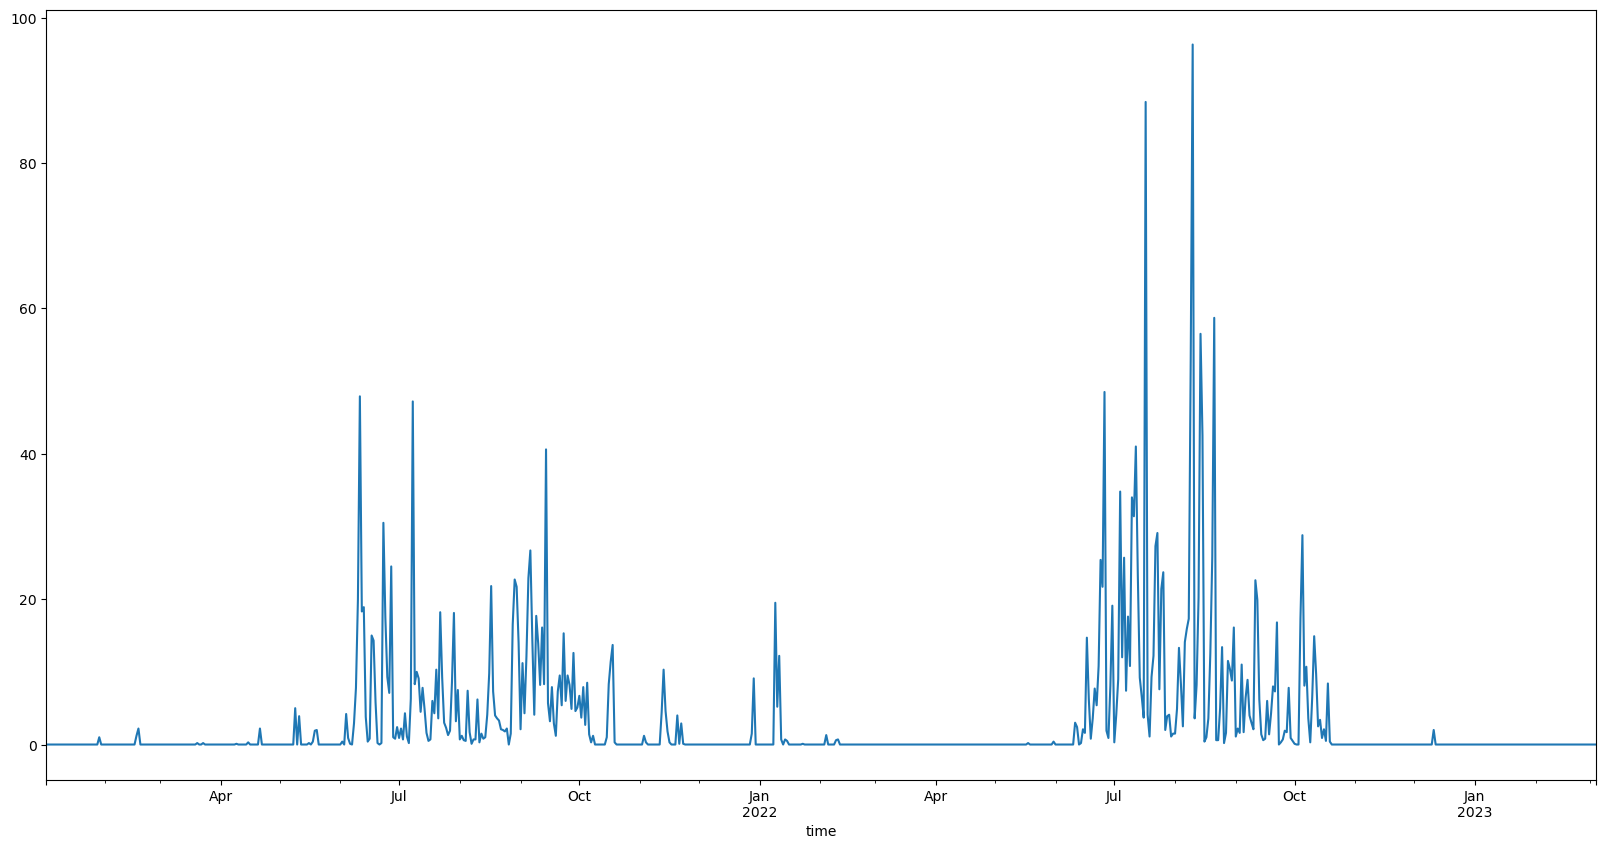

In [15]:
weather['prcp'].plot()

In [16]:
weather

,tmin,tmax,prcp
time,,,
2021-01-02,13.3,26.4,0.0
2021-01-03,12.4,28.6,0.0
2021-01-04,14.5,26.6,0.0
2021-01-05,14.3,27.6,0.0
2021-01-06,16.2,30.0,0.0
...,...,...,...
2023-02-28,18.2,33.3,0.0
2023-03-01,17.6,33.3,0.0
2023-03-02,19.1,33.3,0.0


In [17]:
weather['target'] = weather.shift(-1)['tmax']

In [18]:
weather

,tmin,tmax,prcp,target
time,,,,
2021-01-02,13.3,26.4,0.0,28.6
2021-01-03,12.4,28.6,0.0,26.6
2021-01-04,14.5,26.6,0.0,27.6
2021-01-05,14.3,27.6,0.0,30.0
2021-01-06,16.2,30.0,0.0,26.6
...,...,...,...,...
2023-02-28,18.2,33.3,0.0,33.3
2023-03-01,17.6,33.3,0.0,33.3
2023-03-02,19.1,33.3,0.0,34.6


In [19]:
weather = weather.iloc[:-1,:].copy()

In [20]:
weather

,tmin,tmax,prcp,target
time,,,,
2021-01-02,13.3,26.4,0.0,28.6
2021-01-03,12.4,28.6,0.0,26.6
2021-01-04,14.5,26.6,0.0,27.6
2021-01-05,14.3,27.6,0.0,30.0
2021-01-06,16.2,30.0,0.0,26.6
...,...,...,...,...
2023-02-27,18.5,33.0,0.0,33.3
2023-02-28,18.2,33.3,0.0,33.3
2023-03-01,17.6,33.3,0.0,33.3


In [21]:
reg = Ridge(alpha = 0.1)

In [22]:
predictors = ['prcp', 'tmax', 'tmin']

In [23]:
train = weather.loc[:'2022-08-31']

In [24]:
test = weather.loc['2022-09-01':]

In [25]:
reg.fit(train[predictors], train['target'])

Ridge(alpha=0.1)

In [26]:
predictions = reg.predict(test[predictors])

In [27]:
mean_absolute_error(test['target'], predictions)

0.8450660860240405

In [28]:
combined = pd.concat([test['target'], pd.Series(predictions, index = test.index)], axis = 1)
combined.columns = ['actuals', 'predictions']

In [29]:
combined

,actuals,predictions
time,,
2022-09-01,33.5,31.996024
2022-09-02,31.4,33.426079
2022-09-03,28.9,31.436898
2022-09-04,30.1,29.175409
2022-09-05,31.3,30.206431
...,...,...
2023-02-27,33.3,32.918309
2023-02-28,33.3,33.201284
2023-03-01,33.3,33.199999


<Axes: xlabel='time'>

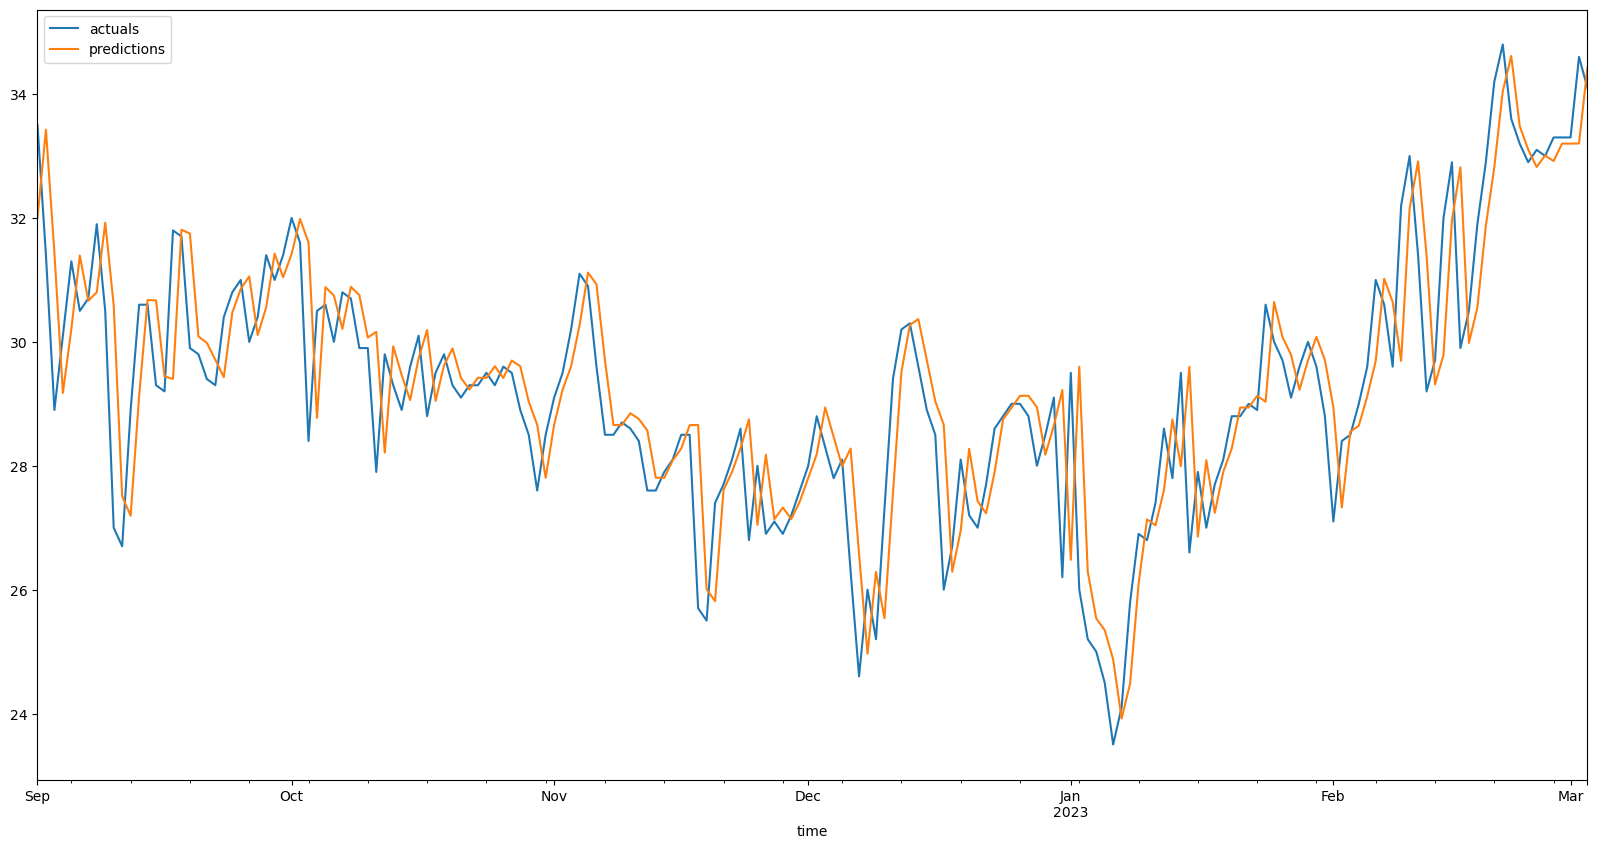

In [30]:
combined.plot()

In [31]:
reg.coef_

array([0.01107709, 0.94538926, 0.00214103])

In [32]:
def predictor(predictors, waether, reg):
    train = weather.loc[:'2022-08-31']
    test = weather.loc['2022-09-01':]
    reg.fit(train[predictors], train['target'])
    predictions = reg.predict(test[predictors])
    error = mean_absolute_error(test['target'], predictions)
    combined = pd.concat([test['target'], pd.Series(predictions, index = test.index)], axis = 1)
    combined.columns = ['actuals', 'predictions']
    return error, combined

In [33]:
weather['month_max'] = weather['tmax'].rolling(30).mean()

In [34]:
weather

,tmin,tmax,prcp,target,month_max
time,,,,,
2021-01-02,13.3,26.4,0.0,28.6,NaN
2021-01-03,12.4,28.6,0.0,26.6,NaN
2021-01-04,14.5,26.6,0.0,27.6,NaN
2021-01-05,14.3,27.6,0.0,30.0,NaN
2021-01-06,16.2,30.0,0.0,26.6,NaN
...,...,...,...,...,...
2023-02-27,18.5,33.0,0.0,33.3,31.073333
2023-02-28,18.2,33.3,0.0,33.3,31.196667
2023-03-01,17.6,33.3,0.0,33.3,31.306667


In [35]:
weather['month_day_max'] = weather['month_max'] / weather['tmax']

In [36]:
weather['max_min'] = weather['tmax'] / weather['tmin']

In [37]:
predictors = ['prcp', 'tmax', 'tmin', 'month_max', 'month_day_max', 'max_min']

In [38]:
weather = weather.iloc[30:,:].copy()

In [39]:
error, combined = predictor(predictors, weather, reg)

In [40]:
error

0.8130912924397747

<Axes: xlabel='time'>

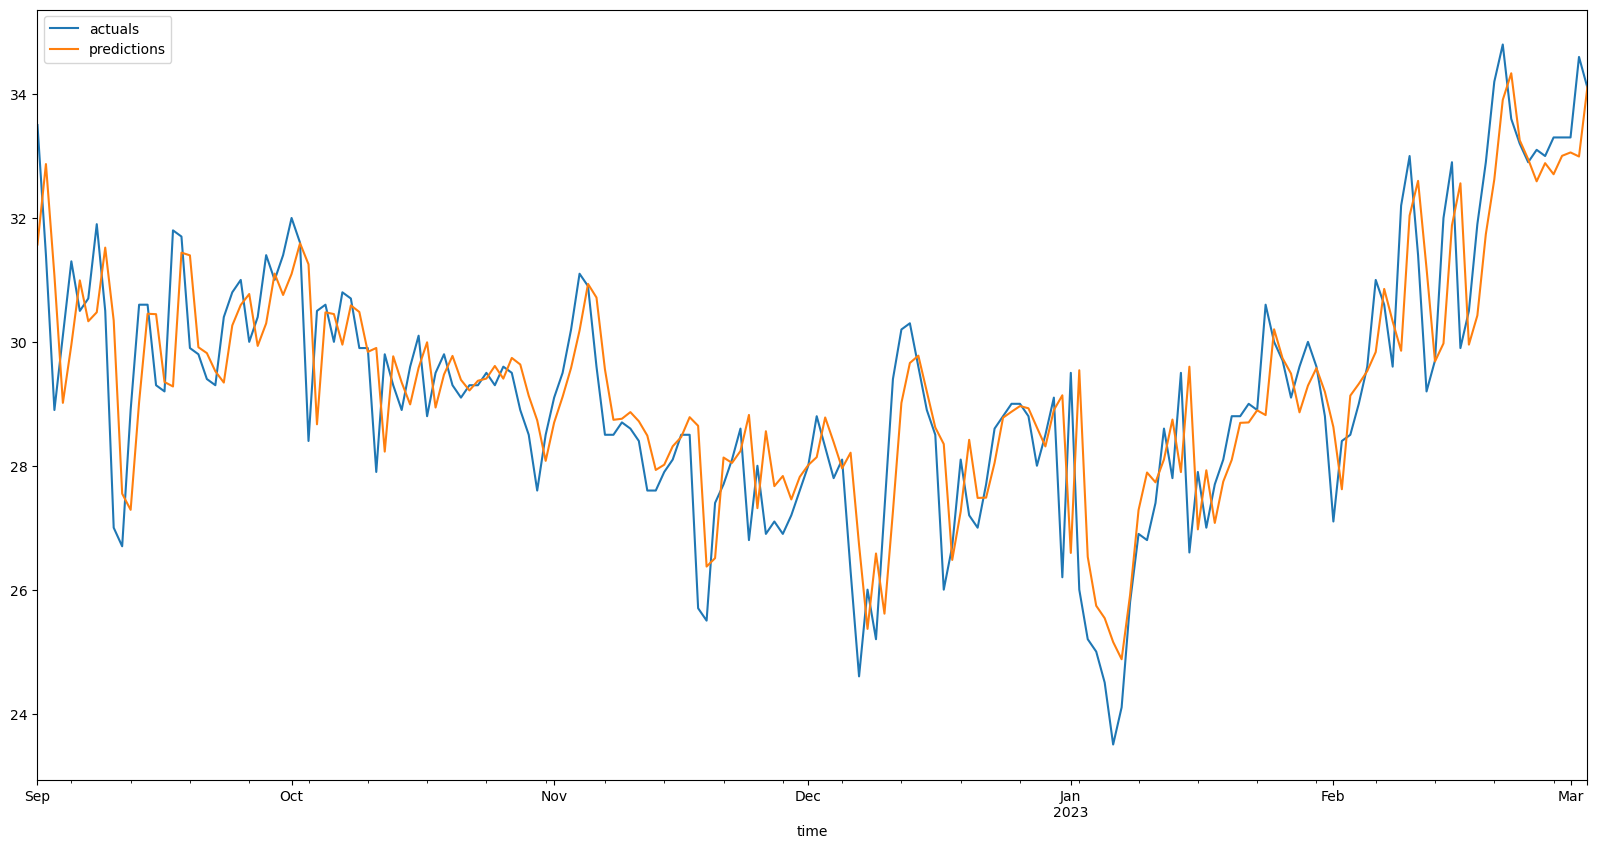

In [41]:
combined.plot()

In [42]:
weather['monthly_avg'] = weather['tmax'].groupby(weather.index.month, group_keys=False).apply(lambda x : x.expanding(1).mean())

In [43]:
weather

,tmin,tmax,prcp,target,month_max,month_day_max,max_min,monthly_avg
time,,,,,,,,
2021-02-01,10.6,26.0,0.0,27.4,28.016667,1.077564,2.452830,26.000000
2021-02-02,10.8,27.4,0.0,28.6,27.976667,1.021046,2.537037,26.700000
2021-02-03,10.7,28.6,0.0,28.4,28.043333,0.980536,2.672897,27.333333
2021-02-04,11.4,28.4,0.0,29.0,28.070000,0.988380,2.491228,27.600000
2021-02-05,12.4,29.0,0.0,27.4,28.036667,0.966782,2.338710,27.880000
...,...,...,...,...,...,...,...,...
2023-02-27,18.5,33.0,0.0,33.3,31.073333,0.941616,1.783784,29.920482
2023-02-28,18.2,33.3,0.0,33.3,31.196667,0.936837,1.829670,29.960714
2023-03-01,17.6,33.3,0.0,33.3,31.306667,0.940140,1.892045,35.009524


In [44]:
weather['day_of_year_avg'] = weather['tmax'].groupby(weather.index.day_of_year, group_keys=False).apply(lambda x : x.expanding(1).mean())

In [45]:
predictors = ['prcp', 'tmax', 'tmin', 'month_max', 'month_day_max', 'max_min', 'day_of_year_avg', 'monthly_avg']

In [46]:
error, combined = predictor(predictors, weather, reg)

In [47]:
error

0.8757599331504997

In [48]:
combined

,actuals,predictions
time,,
2022-09-01,33.5,31.361301
2022-09-02,31.4,32.607124
2022-09-03,28.9,31.044980
2022-09-04,30.1,29.172721
2022-09-05,31.3,30.171050
...,...,...
2023-02-27,33.3,32.344605
2023-02-28,33.3,32.632853
2023-03-01,33.3,33.556424
